#### Import calls

In [38]:
import distutils.util
import os

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import mujoco.viewer
import time
import itertools
import numpy as np

# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output, Audio
clear_output()

# import from other python files
from pend_utils import pd_control
# from cane_builder import CaneEditor

from simple_pid import PID



BROWN = np.array(["0.4, 0.24, 0.0, 1"])

#### Let's build the tree!

In [39]:
branch_model = """
<mujoco model="single_pendulum">
  <option gravity="0 0 -10"/>
  <option integrator="RK4"/>
  <compiler angle="radian"/>

  <visual>
    <headlight diffuse="0.5 0.5 0.5" specular="1 1 1"/>
  </visual>

  <asset>
    <texture type="skybox" builtin="gradient" rgb1=".5 .5 .5" rgb2="0 0 0" width="10" height="10"/>
    <texture type="2d" name="groundplane" builtin="checker" mark="edge" rgb1="1 1 1" rgb2="1 1 1" markrgb="0 0 0" width="300" height="300"/>
    <material name="groundplane" texture="groundplane" texuniform="true" texrepeat="5 5" reflectance="0.3"/>
  </asset>

  <worldbody>
    <geom name="floor" size="5 5 0.01" type="plane" material="groundplane"/>
    <light pos="0 -1 3" diffuse=".5 .5 .5" specular=".5 .5 .5"/>

    <!-- probe -->
    <body name="probe_link" pos="-0.107 0 .75">
      <inertial pos="0.0801087 0 0" quat="0 0.707107 0 0.707107" mass="0.115" diaginertia="0.0230877 0.0230846 0.0230031"/>
      <joint name="probe_joint" pos="0 0 0" axis="1 0 0" type="slide" range="0 0.045"/>
      <geom size="0.005 0.075" pos="0.025 0 0" quat="0.707107 0 0.707106 0" type="cylinder" rgba="0 1 0 1"/>
    </body>

    <!-- tiny blue box -->
    <geom size="0.025 0.025 0.025" type="box" rgba="0 0 1 1"/>

    <!-- branch -->
    <body name="branch_link">
      <inertial pos="0 0 0.395" mass="0.05052" diaginertia="0.01051 0.01051 9.338e-07"/>
      <joint name="base_branch_joint" type="hinge" pos="0 0 0" axis="0 1 0" stiffness="295" springref="0" damping="0.15"/>
      <geom size="0.00608 0.395" pos="0 0 0.395" type="cylinder" rgba="0.4 0.24 0.0 1" solref="0.1 1" solimp=".95 1 0.0025" friction="0 0 0"/> 
    </body>

  </worldbody>

  <actuator>
    <motor name="probe_motor" joint="probe_joint"/>
  </actuator>

  <keyframe>
    <key name="initial" qpos="0 0" qvel="0 0" />
  </keyframe>
</mujoco>
"""

Let's show the initial MJDF:

""

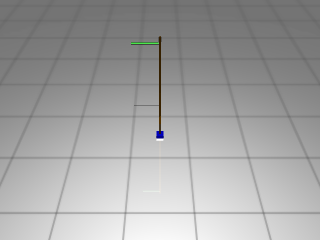

In [40]:
init_model = mujoco.MjModel.from_xml_string(branch_model)
data = mujoco.MjData(init_model)
with mujoco.Renderer(init_model) as renderer:
    mujoco.mj_forward(init_model, data)
    renderer.update_scene(data)
    media.show_image(renderer.render())

Here's the class we'll use to edit the MJDF. Right now all it does is turn the little box red:

In [41]:
class CaneEditor():
    def __init__(self, xml_name):
        self.spec = mujoco.MjSpec.from_string(xml_name)
        self.model = self.spec.compile()

        self.spec.modelname = "edited model"
        geoms = self.spec.worldbody.find_all(mujoco.mjtObj.mjOBJ_GEOM)
        geoms[0].rgba = [1, 0, 0, 1]

    # def add_segment(self):
        

    def show_new_model(self):
        self.model = self.spec.compile()
        data = mujoco.MjData(self.model)
        with mujoco.Renderer(self.model) as renderer:
            mujoco.mj_forward(init_model, data)
            renderer.update_scene(data)
            media.show_image(renderer.render())

In [42]:
# editor = CaneEditor(branch_model)
# editor.show_new_model()

In [43]:
model = mujoco.MjModel.from_xml_string(branch_model)
data = mujoco.MjData(model)

model.opt.timestep = .00001

DURATION = 5
framerate = 60
CTRL_POS = 0.001 # 1 mm
CTRL_POS_UPDATE_RATE = 1 # s

# Kp = np.array([295])
# Kd = np.array([.15])
init_angles = np.zeros(model.njnt)

timevals = []
posvals = []
velvals = []
forcevals = []
contact_x_forces = []

KU=375
TU=0.103
pid = PID(Kp=KU*.45, Ki=200, Kd=1*KU*TU, setpoint=CTRL_POS, output_limits=(-100, 1000))

frames = []
mujoco.mj_resetDataKeyframe(model, data, 0)
with mujoco.Renderer(model) as renderer:
  time_since_last_ctrl_update = 0.0
  while data.time < DURATION:
    if time_since_last_ctrl_update >= CTRL_POS_UPDATE_RATE:
      time_since_last_ctrl_update = 0.0
      CTRL_POS += 0.001
      pid.setpoint = CTRL_POS
      print(f"Time is now {data.time:.3f} s, setting control position to {CTRL_POS:.3f} m")

    # control loop
    current_position = data.qpos[0]
    force = 295*data.qpos[1]+pid(current_position)
    data.ctrl[0] = force

    # step the simulation 

    # update the values 
    mujoco.mj_step(model, data)
    timevals.append(data.time)
    posvals.append(data.qpos.copy())
    velvals.append(data.qvel.copy())
    forcevals.append(data.actuator_force.copy())

    # --- Isolate x-aligned contact force between probe and branch ---
    x_force = 0.0
    if data.ncon > 0:
      for i in range(data.ncon):
          contact = data.contact[i]
          # Get the body IDs for the two geoms in contact
          body1_id = model.geom_bodyid[contact.geom1]
          body2_id = model.geom_bodyid[contact.geom2]
          # Get the body names
          body1 = model.body(body1_id).name
          body2 = model.body(body2_id).name
          # Check if this contact is between probe_link and branch_link
          if (("probe_link" in [body1, body2]) and ("branch_link" in [body1, body2])):
              # Get the contact force (6D: [fx, fy, fz, tx, ty, tz])
              force = np.zeros(6)
              mujoco.mj_contactForce(model, data, i, force)
              # Rotate the force into the world frame from the contact frame
              R = np.array(contact.frame).reshape(3,3)
              force_world = R @ force[:3]
              # Add the x-component (force[0]) in the contact frame
              x_force += force_world[0]
      contact_x_forces.append(x_force)
    else:
      contact_x_forces.append(0.0)
    # --------------------------------------------------------------
    if len(frames) < data.time*framerate:
      renderer.update_scene(data)
      pixels = renderer.render()
      frames.append(pixels)
    time_since_last_ctrl_update += model.opt.timestep

media.show_video(frames, fps=framerate)
  

Time is now 1.000 s, setting control position to 0.002 m
Time is now 2.000 s, setting control position to 0.003 m
Time is now 3.000 s, setting control position to 0.004 m
Time is now 4.000 s, setting control position to 0.005 m


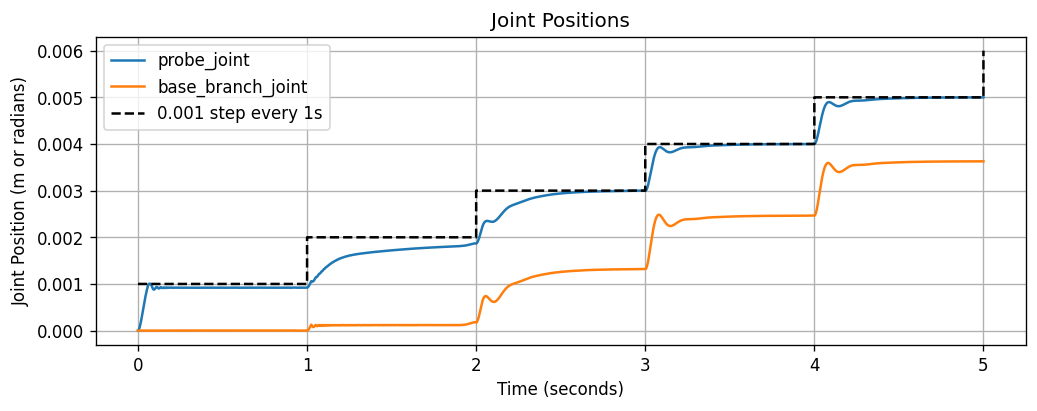

In [44]:
dpi = 120
width = 1200
height = 400
figsize = (width/dpi, height/dpi)
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

pos_array = np.array(posvals)  # shape: (timesteps, njnt)
  # shape: (timesteps, njnt)
for j in range(model.njnt):
    # Get joint name using the MuJoCo API
    joint_name = model.joint(j).name
    ax.plot(timevals, pos_array[:, j], label=joint_name)


ax.set_title("Joint Positions")
ax.set_ylabel("Joint Position (m or radians)")
ax.set_xlabel("Time (seconds)")

# Add a reference line that steps up by 0.001 every 1 second
step_height = 0.001
step_interval = 1.0
step_times = np.arange(0, timevals[-1]+step_interval, step_interval)
step_values = np.arange(0, step_height*len(step_times), step_height)
# Interpolate to match the timevals for plotting as a step function
step_ref = np.zeros_like(timevals)
for i, t in enumerate(timevals):
    idx = np.searchsorted(step_times, t, side='right')
    step_ref[i] = step_values[idx] if idx < len(step_values) else step_values[-1]
ax.step(timevals, step_ref, where='post', linestyle='--', color='black', label='0.001 step every 1s')
ax.legend()
ax.grid(True)

# filename = f"../images/plots/joint_positions_kv{int(model.actuator(0).gainprm[0])}_dt{model.opt.timestep}.png"
# fig.savefig(filename)

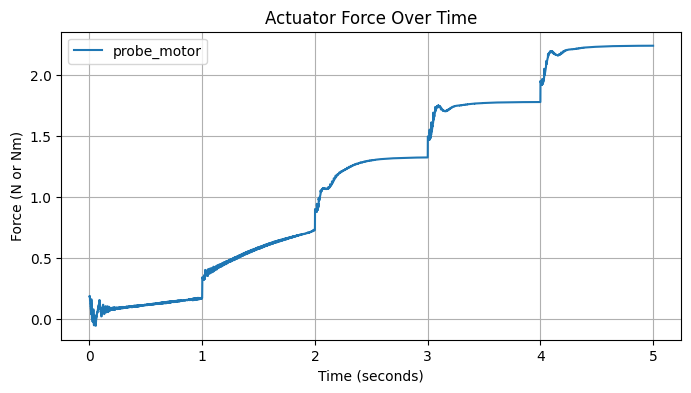

In [45]:
force_array = np.array(forcevals)  # shape: (timesteps, n_actuator)
fig, ax = plt.subplots(figsize=(8, 4))
for i in range(model.nu):
    actuator_name = model.actuator(i).name
    ax.plot(timevals, force_array[:, i], label=actuator_name)
ax.set_title("Actuator Force Over Time")
ax.set_ylabel("Force (N or Nm)")
ax.set_xlabel("Time (seconds)")
ax.legend()
ax.grid(True)

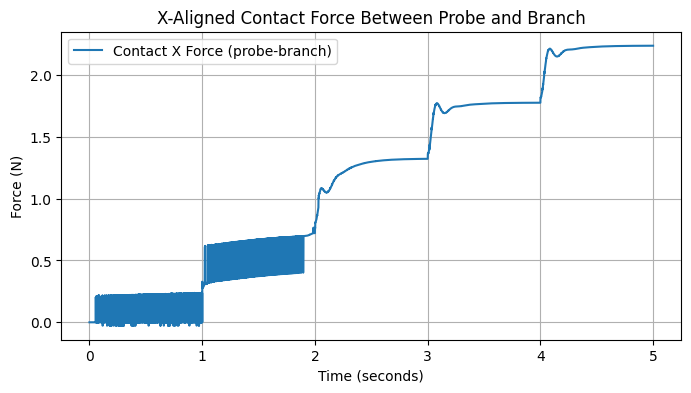

In [46]:
# Plot x-aligned contact force between probe and branch over time
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(timevals, contact_x_forces, label="Contact X Force (probe-branch)")
ax.set_title("X-Aligned Contact Force Between Probe and Branch")
ax.set_ylabel("Force (N)")
ax.set_xlabel("Time (seconds)")
ax.legend()
ax.grid(True)

# filename = f"../images/plots/x_force_kv{int(model.actuator(0).gainprm[0])}_dt{model.opt.timestep}.png"
# fig.savefig(filename)

In [47]:
PROBE_HEIGHT = 0.75  # height of probe above branch in meters
branch_max_disp = pos_array[-1, 0] # branch displacement at the end of the run
print(f"Final branch displacement: {branch_max_disp:.3f} rad")
napkin_math_force = (295* branch_max_disp)/PROBE_HEIGHT
# napkin_math_force = (295* branch_max_disp + .15*branch_max_vel)/.75
print(f"Napkin math force: {napkin_math_force:.3f} N")
print(f"Final contact x force: {contact_x_forces[-1]:.3f} N")
print("Last actuator force:", forcevals[-1])

os.system('aplay /usr/share/sounds/sound-icons/cembalo-1.wav &')

print(f"Last probe position: {data.qpos[1]:.6f} m")

Final branch displacement: 0.005 rad
Napkin math force: 1.966 N
Final contact x force: 2.236 N
Last actuator force: [2.236]
Last probe position: 0.003628 m


Playing WAVE '/usr/share/sounds/sound-icons/cembalo-1.wav' : Signed 16 bit Little Endian, Rate 16000 Hz, Mono


      <geom size="0.01 0.01 0.01" pos="0.1 0 0" type="box" rgba="1 0 0 1"/>
      <geom size="0.005 0.0175" pos="0.0975 0 0" quat="0.707107 0.707106 0 0" type="cylinder" rgba="1 0 0 1"/>
      <geom size="0.005 0.025" pos="0.1225 0.0175 0" quat="0.704433 -0.0614407 0.704432 0.0614408" type="cylinder" rgba="1 0 0 1"/>
      <geom size="0.005 0.025" pos="0.1225 -0.0175 0" quat="0.704433 0.0614407 0.704432 -0.0614408" type="cylinder" rgba="1 0 0 1"/>